### MNIST

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
X, y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
type(X[1])

numpy.ndarray

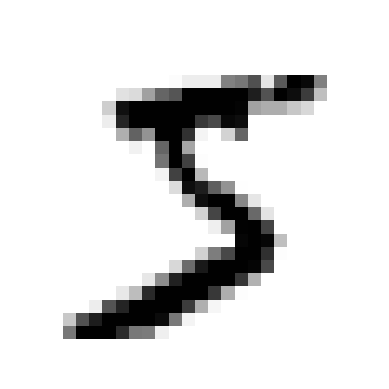

In [5]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis(False)

plot_digit(X[0])

In [6]:
y[0]

'5'

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

In [8]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
some_image = X_test[5]
sgd_clf.predict([some_image])

array([False])

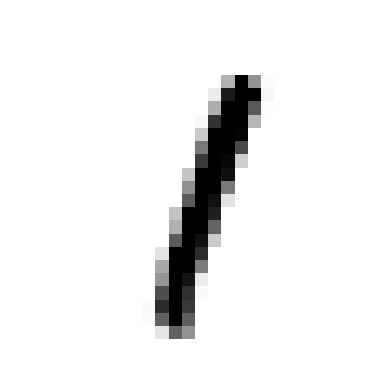

In [11]:
plot_digit(some_image)

### Performance Measures

#### Measuring Accuracy Using Cross-Validation

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_test, y_test_5, cv=3, scoring='accuracy')

array([0.95110978, 0.95439544, 0.96879688])

In [13]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))  # prints False: no 5s detected

False


In [14]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

##### Implementing Cross-Validation

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)   # add shuffle=True if the dataset is not already shuffled

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


#### Confusion Matrices

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
y_train_pred.shape

(60000,)

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [19]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### Precision and Recall

In [20]:
from sklearn.metrics import precision_score, recall_score
print('Precision score:', precision_score(y_train_5, y_train_pred))
print('Recall score:', recall_score(y_train_5, y_train_pred))

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311


In [21]:
from sklearn.metrics import f1_score
print('F1-Score:', f1_score(y_train_5, y_train_pred))

F1-Score: 0.7325171197343847


In [22]:
some_digit = X_train[9]

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-4081.33692831])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [27]:
len(thresholds), len(precisions)

(60000, 60001)

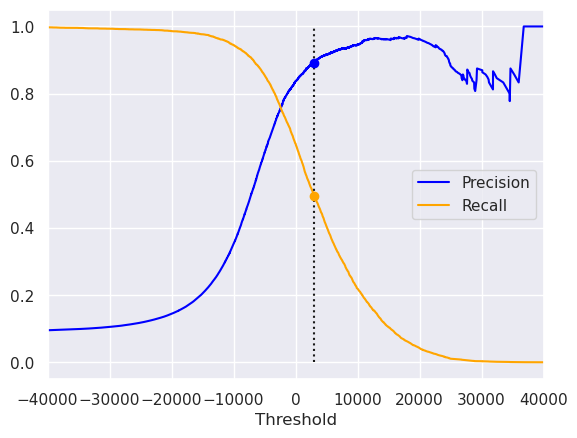

In [28]:
import seaborn as sns
import numpy as np

sns.set_theme()
sns.lineplot(x=thresholds, y=precisions[:-1], label='Precision', color='blue')
sns.lineplot(x=thresholds, y=recalls[:-1], label='Recall', color='orange')

# Draw vertical line
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='Threshold')

# Interpolate y values at threshold
precision_at_thresh = np.interp(threshold, thresholds, precisions[:-1])
recall_at_thresh = np.interp(threshold, thresholds, recalls[:-1])

# Draw dots at the intersection
plt.scatter(threshold, precision_at_thresh, color='blue', zorder=3)
plt.scatter(threshold, recall_at_thresh, color='orange', zorder=3)

plt.xlim(-40000, 40000)
plt.xlabel('Threshold');

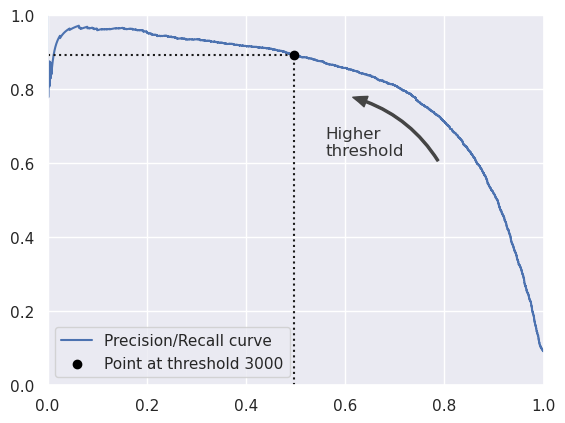

In [29]:
import matplotlib.patches as patches

plt.plot(recalls, precisions, label='Precision/Recall curve')
plt.vlines(recall_at_thresh, 0, precision_at_thresh, colors='k', linestyles='dotted')
plt.hlines(precision_at_thresh, 0, recall_at_thresh, colors='k', linestyles='dotted')
plt.scatter(recall_at_thresh, precision_at_thresh, color='black', zorder=3, label=f'Point at threshold {threshold}')
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.axis([0, 1, 0, 1])
plt.legend();

In [30]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439594

In [31]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

#### The ROC Curve

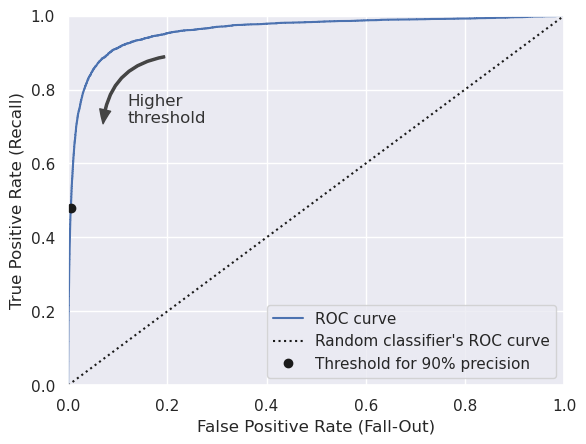

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], 'ko', label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.axis([0, 1, 0, 1])
plt.legend()

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [37]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [38]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

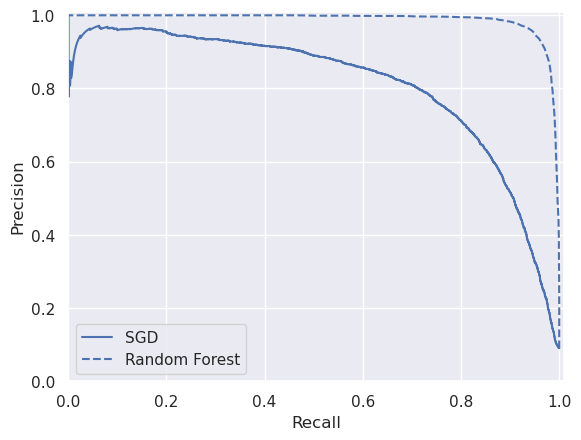

In [39]:
plt.plot(recalls, precisions, 'b-', label='SGD')
plt.plot(recalls_forest, precisions_forest, '--', label='Random Forest')
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend();

In [40]:
y_train_pred_forest = y_scores_forest >= 0.5  # positive proba >= 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [41]:
roc_auc_score(y_train_5, y_probas_forest[:, 1])

0.9983436731328145

### Multiclass Classification

In [42]:
X_train.shape

(60000, 784)

In [43]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

SVC(random_state=42)

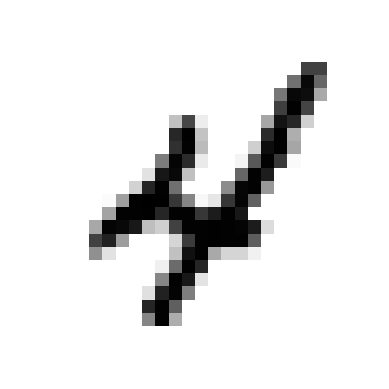

In [51]:
plot_digit(some_digit)

In [44]:
svm_clf.predict([some_digit])

array(['4'], dtype=object)

In [45]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 1.73, -0.29,  4.07,  0.73,  9.31,  7.24,  3.87,  5.97,  3.8 ,
         8.24]])

In [46]:
class_id = some_digit_scores.argmax()
class_id

4

In [48]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [49]:
svm_clf.classes_[class_id]

'4'

In [50]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [52]:
ovr_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [53]:
len(ovr_clf.estimators_)

10

In [55]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [56]:
sgd_clf.decision_function([some_digit]).round(2)

array([[-16343.28, -23384.6 ,  -6695.84,  -8567.75,   8917.48,  -5477.45,
        -11951.15, -16492.51,  -2304.48,  -9235.29]])

In [57]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])